<a href="https://colab.research.google.com/github/satvik-1945/Road-Flaw-Detection/blob/main/Road_Flaw_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
seed_value = 0

import torch, torchvision
import glob
import os

In [3]:
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import cv2
import random
random.seed(seed_value)
import itertools
import pandas as pd

import urllib

In [18]:
import json
import PIL.Image as Image
import shutil
from os.path  import exists
from tqdm.auto import tqdm
# import imagehash
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from  sklearn.metrics import  classification_report , confusion_matrix


In [ ]:
main_path = "/content/drive/MyDrive/Cracks and Grooves/"
path_groove =  main_path +  'Groove'
path_crack = main_path + 'Cracks'

In [ ]:
main_df =  pd.DataFrame()
main_df['images'] = os.listdir(path_groove) + os.listdir(path_crack)
main_df['images']

0       Groove_2269.jpg
1       Groove_2272.jpg
2       Groove_2290.jpg
3       Groove_2283.jpg
4       Groove_2278.jpg
             ...       
4530     Crack_1162.jpg
4531     Crack_1167.jpg
4532     Crack_1165.jpg
4533     Crack_1187.jpg
4534     Crack_1171.jpg
Name: images, Length: 4535, dtype: object

In [ ]:
classes = []
paths = []
for image in main_df['images']:
  class_ = image.split('_')[0]
  if class_ == 'Crack':
    class_ += str('s')
  classes.append(class_)
  paths.append(main_path + class_+'/'+  image)

NameError: ignored

In [ ]:
main_df['classes'] = classes
main_df['path'] = paths

In [ ]:
main_df.tail()

,images,classes,path
4530,Crack_1162.jpg,Cracks,/content/drive/MyDrive/Cracks and Grooves/Crac...
4531,Crack_1167.jpg,Cracks,/content/drive/MyDrive/Cracks and Grooves/Crac...
4532,Crack_1165.jpg,Cracks,/content/drive/MyDrive/Cracks and Grooves/Crac...
4533,Crack_1187.jpg,Cracks,/content/drive/MyDrive/Cracks and Grooves/Crac...
4534,Crack_1171.jpg,Cracks,/content/drive/MyDrive/Cracks and Grooves/Crac...


In [ ]:
def plot_species(df,defect_name):
  plt.figure(figsize = (12,12))
  species_df = df[df['classes']== defect_name].reset_index(drop = True)
  plt.suptitle(defect_name)
  for idx,i in  enumerate(np.random.choice(species_df['path'],32)):
    plt.subplot(8,8,idx + 1)
    image_path = i
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

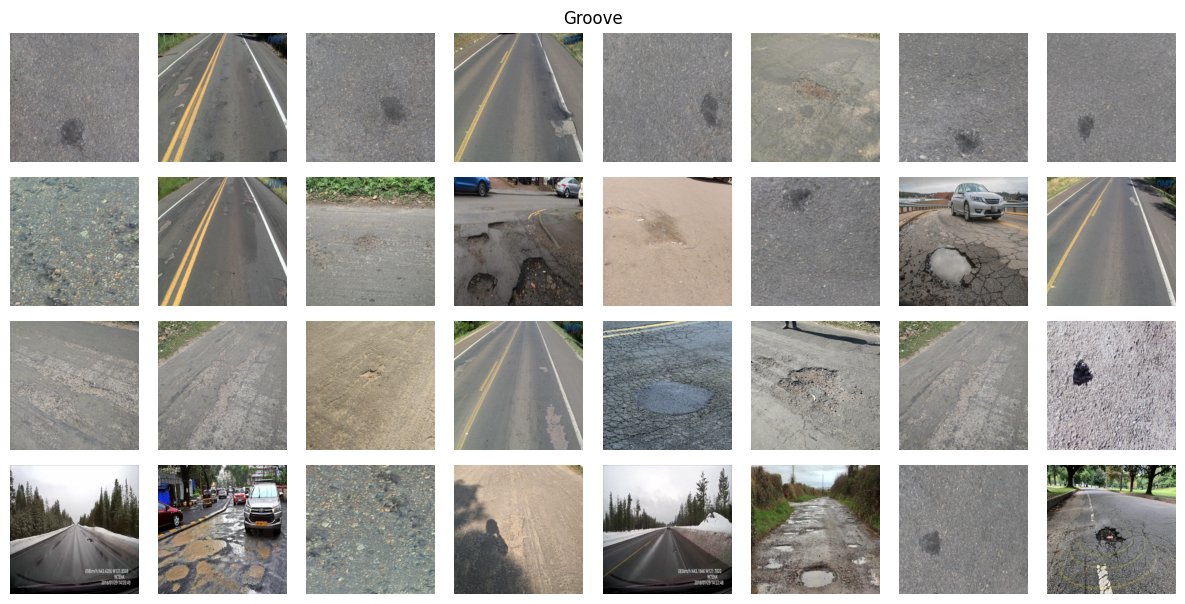

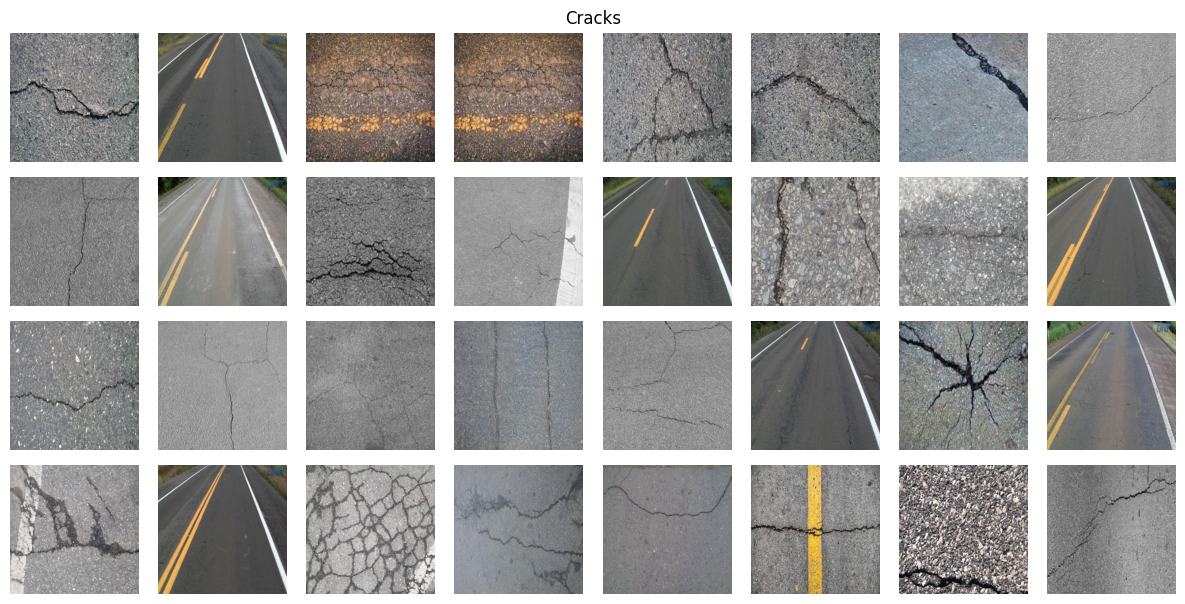

In [ ]:
for defect_name in main_df['classes'].unique():
    plot_species(main_df , defect_name)

In [ ]:
class_names = sorted(os.listdir(main_path))
class_names

['Cracks', 'Groove']

In [ ]:
n_classes = len(class_names)
print(f"Total No of classes : {n_classes}")

Total No of classes : 2


In [ ]:
class_dis = [len(os.listdir(main_path + name))for name in class_names]
class_dis

[2185, 2350]

In [ ]:
fig = px.pie(names= class_names,values= class_dis)
fig.update_layout({'title':{'text':'Class Distribution','x': 0.5
}})

In [ ]:
!pip install imagehash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.2 MB/s eta 0:00:00


#Find Duplicate images

In [ ]:
import imagehash
funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for i in class_names:
    for path in tqdm(glob.glob(main_path + i + '/' + '*.jpg' )):
        image = Image.open(path)
        image_id = os.path.basename(path)
        image_ids.append(image_id)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)

In [ ]:
hashes_all = torch.tensor(hashes_all, dtype=torch.int32).cpu()


In [ ]:
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [ ]:
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}

print('found %d duplicates' % len(dups))

found 902 duplicates


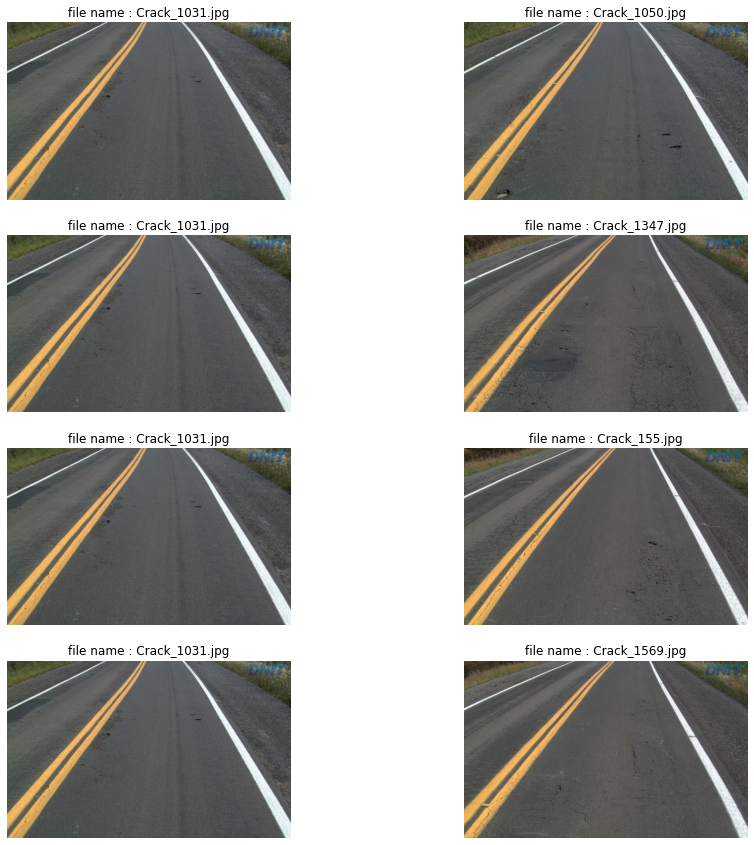

In [ ]:
duplicate_image_ids = sorted(list(dups))

fig, axs = plt.subplots(4, 2, figsize=(15,15))

for row in range(4):
        for col in range(2):
            img_id = duplicate_image_ids[row][col]
            if img_id.split('_')[0] == 'Crack':
                img = Image.open(main_path + 'Cracks/' + img_id)
            else:
                img = Image.open(main_path + 'Groove/' + img_id)
            axs[row, col].imshow(img)
            axs[row, col].set_title("file name : "+ img_id)
            axs[row, col].axis('off')

In [ ]:
img_duplicates = []
for image_dup in duplicate_image_ids:
    img_duplicates.append(image_dup[0])


In [ ]:
imgfiles_crack = []
imgfiles_groove = []


imgfiles_crack = [ f for f in os.listdir(main_path + 'Cracks/') if os.path.isfile(os.path.join(main_path + 'Cracks/',f)) ]
imgfiles_groove = [ f for f in os.listdir(main_path + 'Groove/') if os.path.isfile(os.path.join(main_path + 'Groove/',f)) ]

imgfiles_crack = sorted(imgfiles_crack)
imgfiles_groove = sorted(imgfiles_groove)

print(len(imgfiles_crack))
print(len(imgfiles_groove))

2185
2350


In [ ]:
imgfiles_crack = [img for img in imgfiles_crack if img not in img_duplicates]
imgfiles_groove = [img for img in imgfiles_groove if img not in img_duplicates]

print(len(imgfiles_crack))
print(len(imgfiles_groove))

1928
1965


In [ ]:
imgfiles = imgfiles_crack + imgfiles_groove
imgfiles = sorted(imgfiles)
random.shuffle(imgfiles)
print(len(imgfiles))

3893


In [ ]:
os.makedirs('/content/drive/MyDrive/crack+groove/')

os.makedirs('/content/drive/MyDrive/crack+groove/train/')
os.makedirs('/content/drive/MyDrive/crack+groove/test/')

os.makedirs('/content/drive/MyDrive/crack+groove/train/crack')
os.makedirs('/content/drive/MyDrive/crack+groove/test/crack')

os.makedirs('/content/drive/MyDrive/crack+groove/train/groove')
os.makedirs('/content/drive/MyDrive/crack+groove/test/groove')

In [ ]:
test_ratio = 0.2
train_imgs,test_imgs = np.split(np.array(imgfiles),[int(len(imgfiles)*(1-test_ratio))])
print(train_imgs[0:3])
print(test_imgs[0:3])


['Groove_1093.jpg' 'Crack_1554.jpg' 'Crack_1431.jpg']
['Groove_799.jpg' 'Crack_2144.jpg' 'Groove_1067.jpg']


In [ ]:
print(len(test_imgs))

779


In [ ]:
print(len(train_imgs))

3114


In [ ]:
train = []
test = []

for name_train in train_imgs:
    if name_train.split('_')[0] == 'Crack':
        train.append(main_path + 'Cracks/' + name_train)
    else:
        train.append(main_path + 'Groove/' + name_train)


for name_test in test_imgs:
    if name_test.split('_')[0] == 'Crack':
        test.append(main_path + 'Cracks/' + name_test)
    else:
        test.append(main_path + 'Groove/' + name_test)


print(train[0:3])
print(test[0:10])

['/content/drive/MyDrive/Cracks and Grooves/Groove/Groove_1093.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_1554.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_1431.jpg']
['/content/drive/MyDrive/Cracks and Grooves/Groove/Groove_799.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_2144.jpg', '/content/drive/MyDrive/Cracks and Grooves/Groove/Groove_1067.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_1212.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_1232.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_1370.jpg', '/content/drive/MyDrive/Cracks and Grooves/Groove/Groove_1879.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_536.jpg', '/content/drive/MyDrive/Cracks and Grooves/Cracks/Crack_94.jpg', '/content/drive/MyDrive/Cracks and Grooves/Groove/Groove_960.jpg']


In [ ]:
import re

for name in train:
    if re.findall(r"[\w']+", name)[6] == 'Groove':
        shutil.copy(name, '/content/drive/MyDrive/crack+groove/train/groove/')
    if re.findall(r"[\w']+", name)[6] == 'Cracks':
        shutil.copy(name, '/content/drive/MyDrive/crack+groove/train/crack/')

for name in test:
    if re.findall(r"[\w']+", name)[6] == 'Groove':
        shutil.copy(name, '/content/drive/MyDrive/crack+groove/test/groove/')
    if re.findall(r"[\w']+", name)[6] == 'Cracks':
        shutil.copy(name, '/content/drive/MyDrive/crack+groove/test/crack/')

In [ ]:
# count the contents in each folder
_, _, files = next(os.walk("/content/drive/MyDrive/crack+groove/train/crack/"))
print(len(files))

_, _, files = next(os.walk("/content/drive/MyDrive/crack+groove/train/groove/"))
print(len(files))

_, _, files = next(os.walk("/content/drive/MyDrive/crack+groove/test/crack/"))
print(len(files))

_, _, files = next(os.walk("/content/drive/MyDrive/crack+groove/test/groove/"))
print(len(files))

1548
1566
380
399


#Modelling


In [6]:
train_path = '/content/drive/MyDrive/crack+groove/train'
test_path = '/content/drive/MyDrive/crack+groove/test'

In [7]:
train_names =  sorted(os.listdir(train_path))
test_names = sorted(os.listdir(test_path))

In [8]:
train_names

['crack', 'groove']

In [9]:
assert train_names == test_names

In [10]:
n_classes = len(train_names)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 2


In [11]:
import tensorflow
from tensorflow import keras

# Data
from keras.preprocessing.image import ImageDataGenerator

# Model
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Transfer Learning Models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, MobileNetV2, InceptionResNetV2

# set random set
tensorflow.random.set_seed(seed_value)

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2
)

test_gen = ImageDataGenerator(rescale=1./255)

# Load Data
train_ds = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="training"
)

val_ds = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="validation"
)

test_ds = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    shuffle=False,
    batch_size=32,
    target_size=(256,256),
)

Found 2492 images belonging to 2 classes.
Found 622 images belonging to 2 classes.
Found 779 images belonging to 2 classes.


#Resnet 152

In [ ]:
name = "ResNet152V2"

# Load Pretrained Model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
resnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_resnet = resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs,
)

In [ ]:
# hist_resnet.summary()

In [ ]:
model_resnet = load_model('/content/drive/MyDrive/Transfer Learning Models/ResNet152V2.h5')
model_resnet.summary()

Model: "ResNet152V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                       

In [ ]:
model_resnet.evaluate(test_ds)

25/25 [==============================] - 597s 24s/step - loss: 0.1277 - accuracy: 0.9538


[0.12773853540420532, 0.9537869095802307]

In [ ]:
#confusion Matrix
Y_pred = model_resnet.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

<ipython-input-15-db9e7403d232>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_resnet.predict_generator(test_ds, 779 // 32+1)


Confusion Matrix
[[373   7]
 [ 29 370]]

Classification Report
              precision    recall  f1-score   support

       crack       0.93      0.98      0.95       380
      groove       0.98      0.93      0.95       399

    accuracy                           0.95       779
   macro avg       0.95      0.95      0.95       779
weighted avg       0.96      0.95      0.95       779



In [ ]:
print(classification_report(test_ds.classes, y_pred, target_names=target_names,digits = 7))

              precision    recall  f1-score   support

       crack  0.9278607 0.9815789 0.9539642       380
      groove  0.9814324 0.9273183 0.9536082       399

    accuracy                      0.9537869       779
   macro avg  0.9546465 0.9544486 0.9537862       779
weighted avg  0.9552998 0.9537869 0.9537819       779



#Xception


In [15]:
model_xception = load_model('/content/drive/MyDrive/Transfer Learning Models/Xception.h5')
model_xception.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                          

In [16]:
model_xception.evaluate(test_ds)

25/25 [==============================] - 366s 14s/step - loss: 0.1317 - accuracy: 0.9589


[0.13167881965637207, 0.9589216709136963]

In [19]:
Y_pred = model_xception.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names,digits=7))

<ipython-input-19-4f2c90d018f2>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_xception.predict_generator(test_ds, 779 // 32+1)


Confusion Matrix
[[362  18]
 [ 14 385]]

Classification Report
              precision    recall  f1-score   support

       crack  0.9627660 0.9526316 0.9576720       380
      groove  0.9553350 0.9649123 0.9600998       399

    accuracy                      0.9589217       779
   macro avg  0.9590505 0.9587719 0.9588859       779
weighted avg  0.9589599 0.9589217 0.9589155       779



#InceptionV3

In [20]:
model_inception = load_model('/content/drive/MyDrive/Transfer Learning Models/InceptionV3.h5')
model_inception.summary()

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                       

In [21]:
model_inception.evaluate(test_ds)

25/25 [==============================] - 158s 6s/step - loss: 0.1376 - accuracy: 0.9448


[0.1375930905342102, 0.9448010325431824]

In [22]:
Y_pred = model_inception.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names,digits = 7))

<ipython-input-22-c26ffea7cd4a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_inception.predict_generator(test_ds, 779 // 32+1)


Confusion Matrix
[[371   9]
 [ 34 365]]

Classification Report
              precision    recall  f1-score   support

       crack  0.9160494 0.9763158 0.9452229       380
      groove  0.9759358 0.9147870 0.9443726       399

    accuracy                      0.9448010       779
   macro avg  0.9459926 0.9455514 0.9447978       779
weighted avg  0.9467229 0.9448010 0.9447874       779



#MobileNETV2

In [23]:
model_mobilenet = load_model('/content/drive/MyDrive/Transfer Learning Models/MobileNetV2.h5')
model_mobilenet.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               

In [24]:
model_mobilenet.evaluate(test_ds)

24/25 [===========================>..] - ETA: 2s - loss: 0.1277 - accuracy: 0.9544

[0.1267526000738144, 0.9550706148147583]

In [25]:
Y_pred = model_mobilenet.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names,digits = 7))

<ipython-input-25-7d457e9cbf1d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_mobilenet.predict_generator(test_ds, 779 // 32+1)


Confusion Matrix
[[373   7]
 [ 28 371]]

Classification Report
              precision    recall  f1-score   support

       crack  0.9301746 0.9815789 0.9551857       380
      groove  0.9814815 0.9298246 0.9549550       399

    accuracy                      0.9550706       779
   macro avg  0.9558280 0.9557018 0.9550703       779
weighted avg  0.9564537 0.9550706 0.9550675       779



#InceptionResNetV2

In [26]:
# name = "InceptionResNetV2"

# # Load Pretrained Model
# base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
# base_model.trainable = False

# # Create Model
# inceptionresnet = Sequential([
#     base_model,
#     GAP(),
#     Dense(256, activation='relu'),
#     Dropout(0.3),
#     Dense(256, activation='relu'),
#     Dropout(0.3),
#     Dense(n_classes, activation='softmax')
# ], name=name)

# # Compile Model
# inceptionresnet.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# # Callbacks
# cbs = [
# #     EarlyStopping(patience=3, restore_best_weights=True),
#     ModelCheckpoint(name + ".h5", save_best_only=True)
# ]

# # Train Model
# hist_inceptionresnet = inceptionresnet.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=cbs
# )

In [27]:
# model_inceptionresnet = load_model('/content/drive/MyDrive/Transfer Learning Models/InceptionResNetV2.h5')
# model_inceptionresnet.summary()

In [28]:
# model_inceptionresnet.evaluate(test_ds)

In [29]:
# Y_pred = model_inceptionresnet.predict_generator(test_ds, 779 // 32+1)
# y_pred = np.argmax(Y_pred, axis=1)

# print('Confusion Matrix')
# print(confusion_matrix(test_ds.classes, y_pred))

# print('\nClassification Report')
# target_names = ['crack', 'groove']

# print(classification_report(test_ds.classes, y_pred, target_names=target_names))

#Plot

In [30]:
# plt.plot(hist_resnet.history['loss'])
# plt.plot(hist_xception.history['loss'])
# plt.plot(hist_inception.history['loss'])
# plt.plot(hist_mobilenet.history['loss'])
# plt.plot(hist_inceptionresnet.history['loss'])

# plt.title('training loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['ResNet152V2', 'Xception', 'InceptionV3', 'MobileNetV2', 'InceptionResNetV2'], loc='upper right')
# plt.show()
